This notebook consists of an exploratory data analysis for the normal data available in the 3W Dataset. For more details about the dataset, check [VARGAS et al. (2019)](https://linkinghub.elsevier.com/retrieve/pii/S0920410519306357). For more in-depth exploratory analysis of the 3W Dataset and others process systems engineering datasets, check [MELO et al. (2022)](https://www.sciencedirect.com/science/article/abs/pii/S0098135422003003).

In [1]:
EVENT = 8

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

import gc

In [3]:
plt.rc('font', family='serif', size=12) # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

## Reference table of variables

In [4]:
tags = {'P-PDG':'Pa', 
        'P-TPT':'Pa', 'T-TPT':'degC',
         'P-MON-CKP':'Pa', 'T-JUS-CKP':'degC', 
         'P-JUS-CKGL':'Pa', 'QGL': 'sm^3/s'}

names = ['Pressure at the PDG',
         'Pressure at the TPT',
         'Temperature at the TPT',
         'Pressure upstream of the PCK',
         'Temperature downstream of the PCK',
         'Pressure downstream of the GLCK',
         'Gas lift flow rate']

reference_table = pd.DataFrame(index=np.arange(1,len(names)+1))
reference_table.index.name='Number'
reference_table['Tag'] = tags.keys()
reference_table['Name'] = names
reference_table['Unit'] = tags.values()
reference_table

,Tag,Name,Unit
Number,,,
1,P-PDG,Pressure at the PDG,Pa
2,P-TPT,Pressure at the TPT,Pa
3,T-TPT,Temperature at the TPT,degC
4,P-MON-CKP,Pressure upstream of the PCK,Pa
5,T-JUS-CKP,Temperature downstream of the PCK,degC
6,P-JUS-CKGL,Pressure downstream of the GLCK,Pa
7,QGL,Gas lift flow rate,sm^3/s


## Data importing

In [5]:
%%time

PATH = os.path.join('..', '..', 'dataset', str(EVENT))

if os.path.exists(PATH):
    files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]

columns_to_keep = list(tags.keys()) + ['class']

dfs = {}

for file in files:
    df = pd.read_parquet(os.path.join(PATH, file), engine="pyarrow")
    df = df.reindex(columns=columns_to_keep)
    
    dfs[os.path.splitext(file)[0]] = df

wells_numbers = []
    
for key in dfs.keys():
    if 'SIMULATED' in key or 'DRAWN' in key:
        continue
    else:
        wells_numbers.append(int(key[8:10]))
    
print('Data read!\nNumber of instances: ',len(dfs))
print('Number of real instances: ',len(wells_numbers))

Data read!
Number of instances:  95
Number of real instances:  14
CPU times: user 4.92 s, sys: 2.47 s, total: 7.39 s
Wall time: 8.12 s


## Visualization

### Comparison of simulation and real data

In the following graphs, simulations are plotted in black and real data are plotted in orange. All data are standardized to zero mean and unit variance.

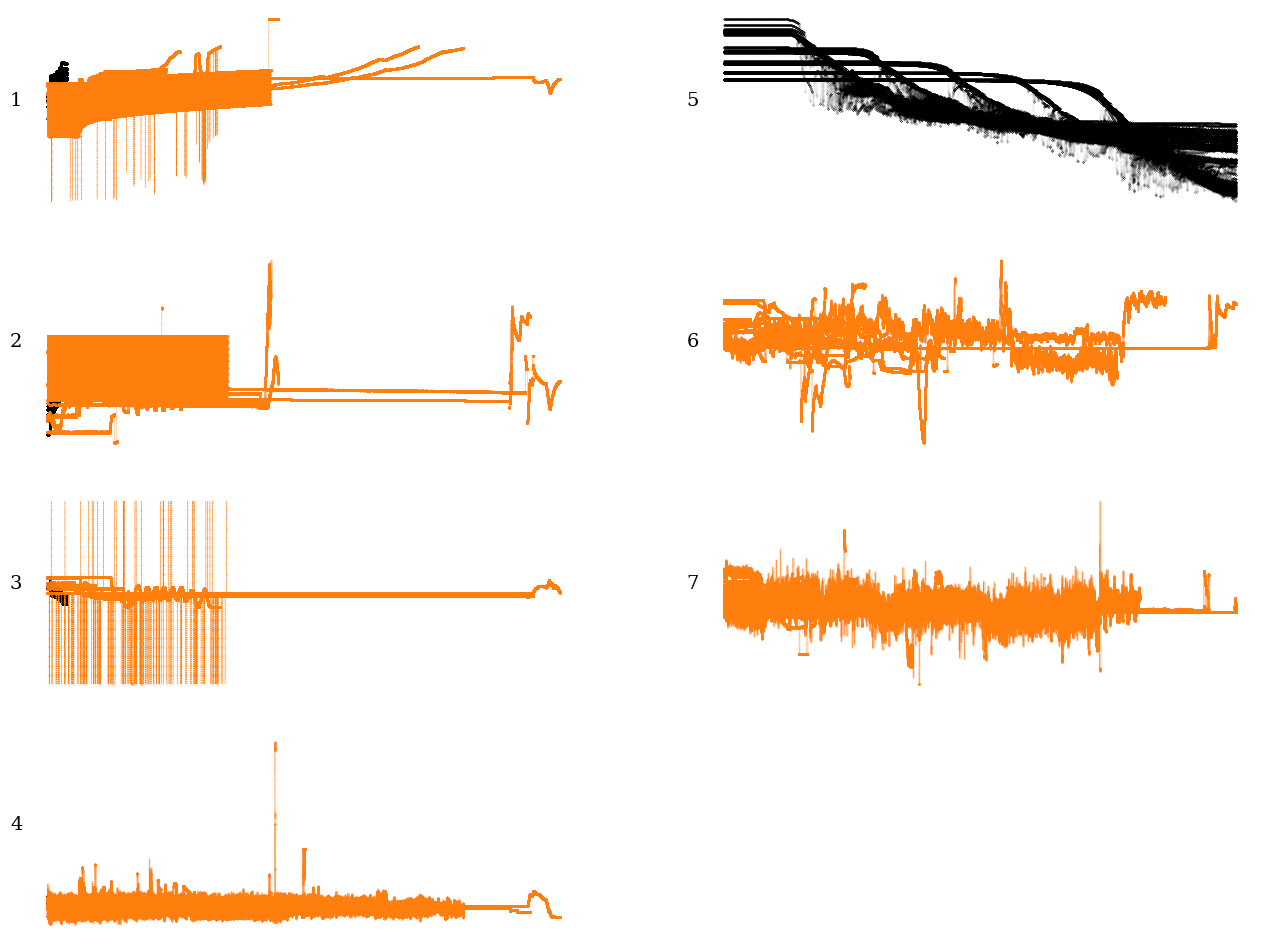

In [6]:
fig, ax1 = plt.subplots(4, 2, figsize=(16, 12))#sharex=True,

for key in sorted(dfs.keys()):
    
    if 'WELL' in key:
        c = color_cycle[1]
        lw = 0.3
        ls='--'
        alpha=1
        ms=0.1
    elif 'SIMULATED' in key:
        c = 'k'
        lw = 0.3
        ls=''
        alpha=0.3
        ms=0.1
        
    df_plot = dfs[key]
    
    for i in range(4):
        ax1[i,0].plot(np.arange(df_plot.shape[0]),
                    (df_plot.iloc[:,i]-df_plot.iloc[:,i].mean())/df_plot.iloc[:,i].std(ddof=1),
                     c=c,linewidth=lw,ls=ls,marker='.',ms=ms,alpha=alpha)
        ax1[i][0].set_ylabel(i+1,rotation=0,fontsize=14)

        if i + 4 < 7:
            ax1[i,1].plot(np.arange(df_plot.shape[0]),
                        (df_plot.iloc[:,i+4]-df_plot.iloc[:,i+4].mean())/df_plot.iloc[:,i+4].std(ddof=1),
                         c=c,linewidth=lw,ls=ls,marker='.',ms=ms,alpha=alpha)
            ax1[i][1].set_ylabel(i+1+4,rotation=0,fontsize=14)
        
        for j in range(2):
            ax1[i][j].set_yticks([])
            ax1[i][j].spines["top"].set_visible(False)
            ax1[i][j].spines["right"].set_visible(False)
            ax1[i][j].spines["left"].set_visible(False)
            if i<(8-1):
                ax1[i][j].set_xticks([])
                ax1[i][j].spines["bottom"].set_visible(False)
                ax1[i][j].xaxis.set_ticks_position('none')
            else:
                for label in ax1[i][j].get_xticklabels():
                    label.set_rotation(45)
                    label.set_ha('right')

In [7]:
gc.collect()

40

Simulation curves have similar shapes. Real data show similar tendencies to the simulations, but the shapes of the curves are different.

### Plotting all instances

In the following graphs, the light red background indicates faulty transient periods, in which the abnormal events are still developing; the dark red background indicates faulty steady-state periods, in which the abnormal events are fully developed.

#### Simulations

CPU times: user 58.6 s, sys: 361 ms, total: 58.9 s
Wall time: 59.1 s


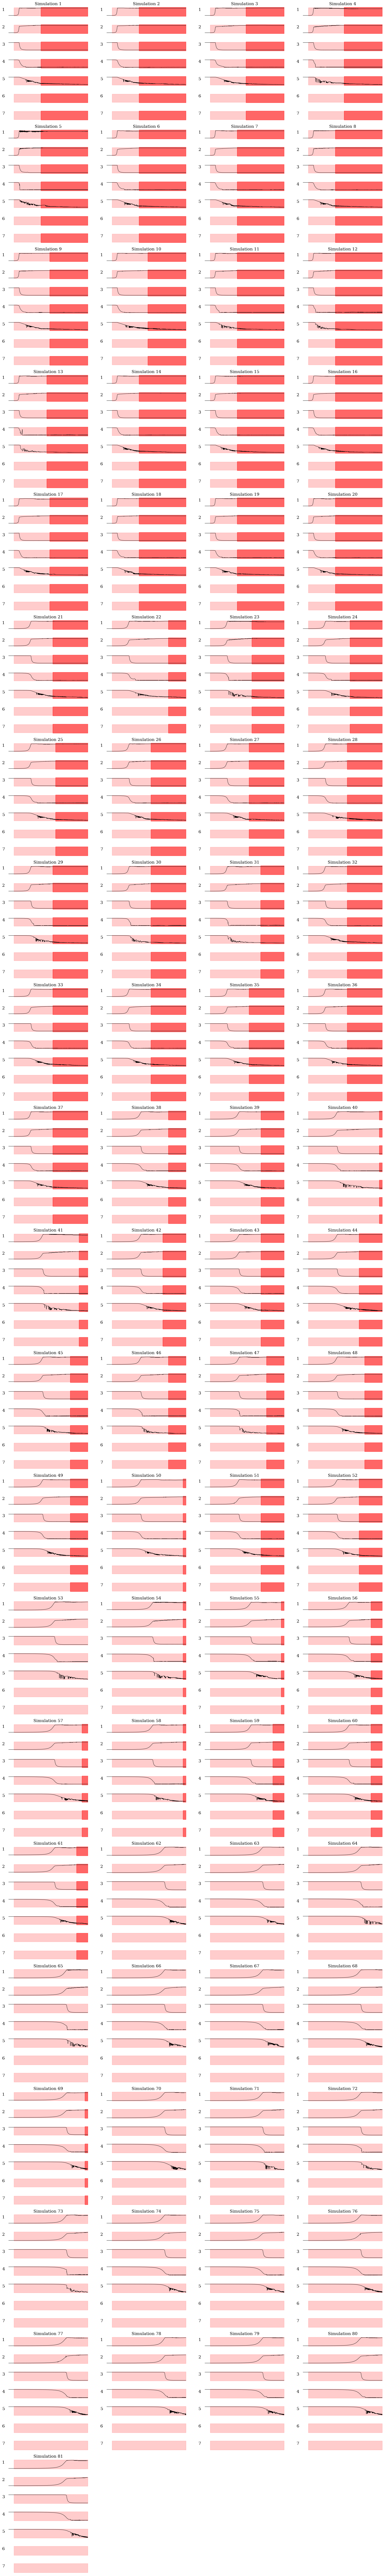

In [8]:
%%time

fig = plt.figure(constrained_layout=True, figsize=(18, 120))
subfigs = fig.subfigures(21, 4, wspace=0.07)

j=0

for key in sorted(dfs.keys()):
    
    if 'WELL' in key:
        continue
    elif 'SIMULATED' in key:
        pass
        
    df_plot = dfs[key]
    
    ax1 = subfigs.ravel()[j].subplots(7, 1, sharex=True)
    
    for i in range(7):
        ax1[i].plot(df_plot.index,df_plot.iloc[:,i],c='k',linewidth=0.8)
        ax1[i].set_ylabel(i+1,rotation=0,fontsize=14)
        ax1[i].set_yticks([])
        ax1[i].spines["top"].set_visible(False)
        ax1[i].spines["right"].set_visible(False)
        ax1[i].spines["left"].set_visible(False)
        ax1[i].fill_between(df_plot.index, ax1[i].get_ylim()[0], ax1[i].get_ylim()[1],
                               where=(df_plot['class']==(EVENT+100)).to_numpy(dtype=bool, na_value=False), 
                               alpha=0.2,color='red',)#transform=ax1[i,j].get_xaxis_transform(),interpolate=True)
        ax1[i].fill_between(df_plot.index,ax1[i].get_ylim()[0], ax1[i].get_ylim()[1],
                               where=(df_plot['class']==EVENT).to_numpy(dtype=bool, na_value=False), 
                             alpha=0.6,color='red')#transform=ax1[i,j].get_xaxis_transform(),)
        
        ax1[i].set_xticks([])
        ax1[i].spines["bottom"].set_visible(False)
        ax1[i].xaxis.set_ticks_position('none')
    ax1[0].set_title(f'Simulation {int(key[-5:])}')

    gc.collect()
    
    j+=1
        
# suptitle instead of title makes the execution very slow, because of the constrained_layout used
#for j in range(len(subfigs.ravel())):
#    subfigs.ravel()[j].suptitle(f'Simulation {int(key[-5:])}')

Some transient periods are longer than others. In the latter cases, there are no faulty steady-state periods.